In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pyreadr
data_ml = pyreadr.read_r("data/data_ml.Rdata")
data_ml = data_ml['data_ml']
data_ml.shape

(283380, 99)

In [4]:
# Keep the feature's column names (hard-coded, beware!)
features = data_ml.columns[2:94]  
max_n_stocks = data_ml["stock_id"].value_counts().max()
data_ml = data_ml.loc[data_ml.groupby("stock_id").date.transform("count") == max_n_stocks]
data_ml = data_ml.loc[data_ml['date'] >= pd.Timestamp("2005-01-01")]
data_ml['date'] = pd.to_datetime(data_ml['date'])
# Starting point for backtest
sep_oos = pd.to_datetime("2010-01-01")

ticks = data_ml['stock_id'].astype('category').cat.categories.tolist()
ticks_df = pd.DataFrame({"stock_id":ticks}).reset_index()

N = len(ticks)

t_oos = data_ml.loc[data_ml['date'] > sep_oos, 'date'].unique()
t_oos = pd.to_datetime(t_oos).sort_values()

nb_port = 3

In [5]:
import xgboost as xgb
from sklearn.linear_model import Lasso
def get_equal_weights(test_data, weights=None):
    weights = np.ones(len(test_data), dtype=int) if weights is None else weights
    return pd.DataFrame({"stock_id":test_data['stock_id'], "weights":weights/weights.sum()})

def get_xgb_weights(train_data, test_data, features):
    X_train = train_data[features]
    y_train = train_data["R12M_Usd"] / np.exp(train_data["Vol1Y_Usd"])
    X_test = test_data[features]
    ind = (y_train > np.quantile(y_train, 0.2)) & (y_train < np.quantile(y_train, 0.8))
    X_train = X_train.loc[ind,]
    y_train = y_train.loc[ind]
    
    # Initialize model
    params = {
        "eta": 0.3,                      
        "objective": "reg:squarederror", 
        "max_depth": 4,          
        "n_estimators": 80,
        "subsample":0.5,
        "eval_metric":"rmse",
        "random_state":2025
    }
    xgb_r = xgb.XGBRegressor(**params) 
    
    # Fitting the model 
    
    xgb_r.fit(X_train, y_train) 
    
    # Predict the model 
    pred = xgb_r.predict(X_test) 
    weights = pred > np.median(pred)
    return get_equal_weights(test_data, weights)


def get_lr_weights(train_data, test_data, features):
    # print(train_data)
    X_train = train_data[features]
    y_train = train_data["R12M_Usd"] / np.exp(train_data["Vol1Y_Usd"])
    X_test = test_data[features]
    ind = (y_train > np.quantile(y_train, 0.2)) & (y_train < np.quantile(y_train, 0.8))
    X_train = X_train.loc[ind,]
    y_train = y_train.loc[ind]
    lasso_reg = Lasso(alpha=0.001, max_iter=1000)
    lasso_reg.fit(X_train, y_train)
    pred = lasso_reg.predict(X_test)
    weights = pred > np.median(pred)
    return get_equal_weights(test_data, weights)



In [6]:
## Backtesting function
m_offset = 12                                          # Offset in months for buffer period
train_size = 5                                         # Size of training set in years

def backtest(t_oos, data_ml):
    portf_weights = np.zeros((len(t_oos), nb_port, N))
    portf_returns = np.zeros((len(t_oos), nb_port))
    for t, curr_t in enumerate(t_oos):
        # if t > 36:
        #     break
        if t % 12 == 0:
            print(curr_t)
        train_data = data_ml[(data_ml['date'] < curr_t - pd.Timedelta(days=m_offset * 30)) &  \
                             (data_ml['date'] > curr_t - pd.Timedelta(days=m_offset * 30 + 365 * train_size))].reset_index(drop=True)
        test_data = data_ml[data_ml['date'] == curr_t].reset_index(drop=True)
        realized_returns = test_data['R1M_Usd']
        # print(test_data)
        for i in range(nb_port):
            if i == 0:
                temp_weights = get_equal_weights(test_data)
            elif i == 1:
                temp_weights = get_lr_weights(train_data, test_data, features)
            elif i == 2:
                temp_weights = get_xgb_weights(train_data, test_data, features)
            else:
                raise ValueError(f"Invalid number for nb_port: {nb_port}. Please enter a value from 1 to 3")
            ind = temp_weights.merge(ticks_df, how="left", on="stock_id").index.tolist()
            portf_weights[t,i,ind] = temp_weights["weights"]
            portf_returns[t,i] = np.multiply(temp_weights['weights'], realized_returns).sum()
    return portf_weights, portf_returns
        

In [7]:
portf_weights, portf_returns = backtest(t_oos, data_ml)

2010-01-31 00:00:00
2011-01-31 00:00:00
2012-01-31 00:00:00
2013-01-31 00:00:00
2014-01-31 00:00:00
2015-01-31 00:00:00
2016-01-31 00:00:00
2017-01-31 00:00:00
2018-01-31 00:00:00
2019-01-31 00:00:00


In [8]:
def get_turnover(weights, asset_returns, t_oos):
    """
    weights: shape (t, nb_port, N)
    asset_returns: shape (t, N)
    """
    # Pre-allocate turnover
    turnover = []  # nb_port

    for t in range(1, weights.shape[0]):  # for each portfolio
        # Calculate pre-rebalance weights (after returns)
        curr_return = asset_returns.loc[asset_returns['date']==t_oos[t], ['stock_id', 'R1M_Usd']]
        curr_return = ticks_df.merge(curr_return, how="left", on="stock_id")['R1M_Usd']
        prior_w = weights[t-1,:] * (1 + curr_return)  
        prior_w = prior_w / prior_w.sum()

        # Calculate turnover
        curr_turn = np.sum(np.abs(weights[t,:] - prior_w))  
        turnover.append(curr_turn)

    return np.mean(turnover)

In [9]:
def stationary_bootstrap(array, num, prob):
    N = len(array)
    result = []
    curr_ind = np.random.randint(0, N)
    while num > 0:
        result.append(array[curr_ind])
        select_next = np.random.choice([True, False], p=[1-prob, prob])
        if select_next:
            curr_ind = (curr_ind + 1) % N
        else:
            curr_ind = np.random.randint(0, N)
        num -= 1
    return result
        
def get_bootstrap(returns, t, prob, N):
    initial_val = 1000
    portfolio_val = []
    for i in range(N):
        bootstrap_returns = stationary_bootstrap(returns, t*12, prob)
        portfolio_val.append(initial_val * np.prod(1+np.array(bootstrap_returns)))
    return portfolio_val


def plot_portf_cdf(portfolio_vals, strat_name, t):
    plt.figure(figsize=(8, 5))
    for name, vals in zip(strat_name, portfolio_vals):
        sorted_values = np.sort(vals)
        cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
        plt.plot(sorted_values, cdf, marker='.', linestyle='none', label=name)
    plt.xlabel('Terminal Portfolio Value')
    plt.ylabel('CDF')
    plt.title(f'Empirical CDF of Terminal Portfolio Values ({t}-Year Horizon)')
    plt.legend()
    plt.show()

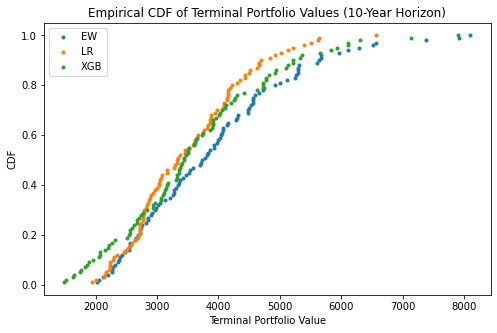

In [14]:
def perf_met_multi(portf_returns, weights, asset_returns, t_oos, strat_name):
    t=10 # Number of years for bootstrap
    metrics_df = pd.DataFrame()
    bootstrap_portf_vals = []
    for j in range(weights.shape[1]):
        turnover = get_turnover(portf_weights[:,j,:], asset_returns, t_oos)
        curr_bootstrap = get_bootstrap(portf_returns[:,j], t, 0.1, 100)
        curr_mean = np.mean(curr_bootstrap)
        curr_std = np.std(curr_bootstrap)
        bootstrap_portf_vals.append(curr_bootstrap)
        metrics_df = pd.concat([metrics_df, pd.DataFrame({"strat":[strat_name[j]], 
                                                          "turnover":[turnover],
                                                          "mean":[np.mean(portf_returns[:,j])],
                                                          "std":[np.std(portf_returns[:,j])], 
                                                          "sharpe":[np.mean(portf_returns[:,j])/np.std(portf_returns[:,j])],
                                                          "bt_mean":[curr_mean],
                                                          "bt_std":[curr_std],
                                                          "bt_sharpe":[curr_mean/curr_std]})], axis=0)
    plot_portf_cdf(bootstrap_portf_vals, strat_name, t)
    return metrics_df

metrics_df = perf_met_multi(portf_returns, portf_weights, data_ml, t_oos, ['EW', "LR", "XGB"])

In [15]:
metrics_df

,strat,turnover,mean,std,sharpe,bt_mean,bt_std,bt_sharpe
0,EW,0.055548,0.012391,0.048187,0.257133,3904.006946,1314.640735,2.969638
0,LR,0.451737,0.011604,0.046160,0.251391,3495.420225,958.169489,3.648019
0,XGB,0.827209,0.011594,0.047621,0.243460,3606.394013,1282.126763,2.812822


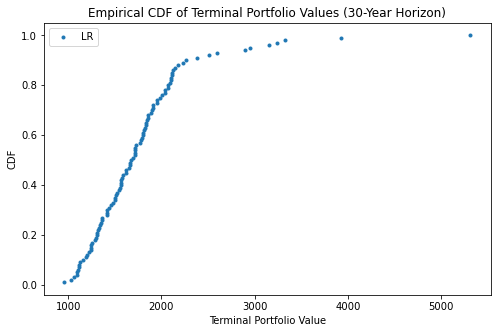

In [131]:
plot_portf_cdf([test], ['LR'])

In [16]:
import numpy as np
arr = list(range(30))
stationary_bootstrap(arr, 20, 0.2)

[26, 27, 28, 29, 0, 1, 2, 3, 4, 5, 6, 29, 2, 3, 4, 5, 6, 7, 8, 9]

In [10]:
1/0.2

5.0

In [30]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.0001)
lasso_reg.fit(data_ml[features], data_ml["R1M_Usd"])

Lasso(alpha=0.0001)

In [32]:
(lasso_reg.coef_ != 0).sum()

37

In [44]:
import xgboost as xgb
params = {
        "eta": 0.3,                      
        "objective": "reg:squarederror", 
        "max_depth": 4,          
        "n_estimators": 80,
        "eval_metric":"rmse",
        "random_state":2025
    }
xgb_r = xgb.XGBRegressor(**params) 

# Fitting the model 

xgb_r.fit(
    data_ml[features], 
    data_ml["R1M_Usd"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric='rmse',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=80,
             n_jobs=None, num_parallel_tree=None, ...)

In [45]:
len(features)

92

In [183]:
xgb_r.evals_result()['validation_0']

OrderedDict([('rmse',
              [0.170902403194844,
               0.16644979111743527,
               0.16340285345940453,
               0.1597972287561289,
               0.15783412755926526,
               0.15548904283629061,
               0.15454407753482585,
               0.15346650875529097,
               0.15284938707011952,
               0.15241796573182131,
               0.15218571978012704,
               0.15068534204783157,
               0.15035509133822558,
               0.14971495193963488,
               0.1489933609730812,
               0.14818767762871934,
               0.14652915689528662,
               0.146233000147902,
               0.14595135680109914,
               0.14585453096500797,
               0.14576012465701377,
               0.1455649728690419,
               0.14550201518514239,
               0.14518298002455723,
               0.14471100773928008,
               0.14458868039034717,
               0.1441574111340092,
              

/Users/alexandermichaeltjhin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8094065741379382, tolerance: 0.5821757173000007
  model = cd_fast.enet_coordinate_descent_gram(
/Users/alexandermichaeltjhin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.47432988591936, tolerance: 0.5821757173000007
  model = cd_fast.enet_coordinate_descent_gram(
/Users/alexandermichaeltjhin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5090414146852709, tolerance: 0.5821757173000007
  model = cd_fast.enet_coordinate_descent_gram(
/Users

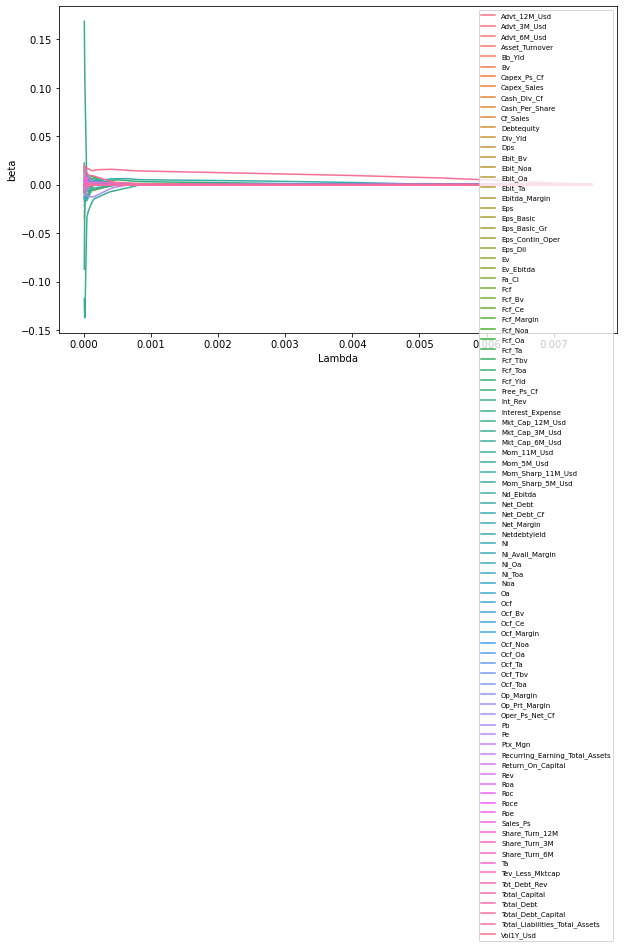

In [159]:
import numpy as np
import pandas as pd
from sklearn.linear_model import lasso_path
import matplotlib.pyplot as plt
import seaborn as sns

# Compute LASSO path
features_short = ["Ebit_Ta", "Eps", "Mkt_Cap_3M_Usd", "Mom_5M_Usd",
"Pb", "Pe", "Total_Debt_Capital", "Vol1Y_Usd"]
alphas_lasso, coefs_lasso, _ = lasso_path(data_ml[features], data_ml["R1M_Usd"], alphas=None)

# Reshape into long format for plotting
coefs_df = pd.DataFrame(coefs_lasso.T, columns=features)
coefs_df['Lambda'] = alphas_lasso
coefs_long = coefs_df.melt(id_vars='Lambda', var_name='Feature', value_name='beta')

# Take first 120 rows (like R code)
# coefs_long_subset = coefs_long.iloc[:120]

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=coefs_long, x='Lambda', y='beta', hue='Feature')
plt.ylabel("beta")
# plt.gca().set_aspect(0.25)
plt.legend(fontsize=7)
plt.show()
